# Inversão 2D do relevo do embasamento

Este código está escrito em linguagem [Python](https://www.python.org/) e utiliza o subpacote [gravmag](http://www.fatiando.org/api/gravmag.html#module-fatiando.gravmag) do [Fatiando a Terra](http://www.fatiando.org/index.html).

### Pacotes necessários

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from fatiando.inversion import Smoothness1D
from fatiando.gravmag.basin2d import PolygonalBasinGravity
from fatiando.gravmag import talwani
from fatiando.mesher import Polygon
from fatiando.vis import mpl
from fatiando import utils
import numpy as np

/home/vanderlei/anaconda2/envs/SEGEO2017/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/vanderlei/anaconda2/envs/SEGEO2017/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


### Dados sintéticos produzidos por um polígono 2D

In [2]:
xs = np.linspace(0, 100000, 100)[::-1]
depths = (-1e-15*(xs - 50000)**4 + 8000 -
          3000*np.exp(-(xs - 70000)**2/(10000**2)))
depths -= depths.min()  # Reduce depths to zero
props = {'density': -300}
model = Polygon(np.transpose([xs, depths]), props)
x = np.linspace(0, 100000, 100)
z = -100*np.ones_like(x)
data = utils.contaminate(talwani.gz(x, z, [model]), 2.0, seed=0)

### Corpo verdadeiro

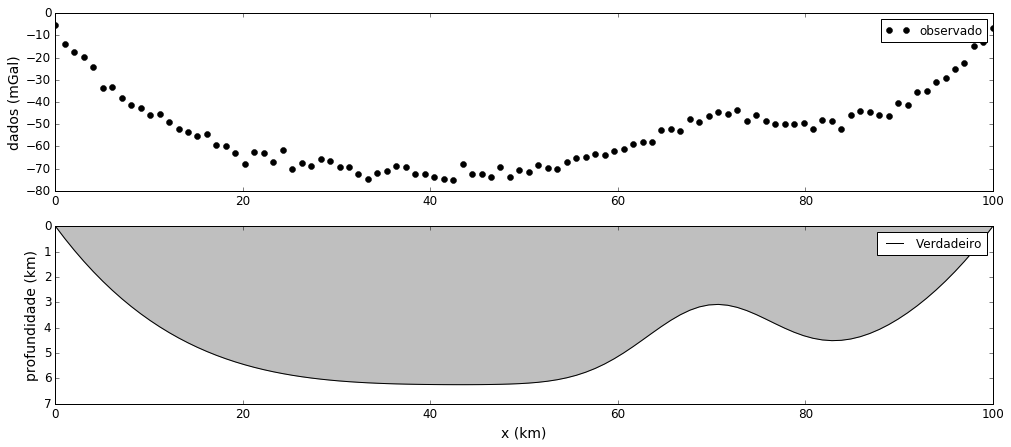

In [3]:
factor = 1.4
plt.close('all')
plt.figure(figsize=(factor*12,factor*5))
plt.subplot(2, 1, 1)
plt.plot(0.001*x, data, 'ok', label='observado')
plt.legend(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('dados (mGal)', fontsize=14)
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5, label='Verdadeiro')
ax.invert_yaxis()
mpl.m2km()
plt.legend(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('profundidade (km)', fontsize=14)
plt.xlabel('x (km)', fontsize=14)
plt.savefig('modelo.png', dpi=300)
plt.show()

### Estimativas obtidas com diferentes contrastes de densidade

In [4]:
# Make the solver using smoothness regularization and run the inversion
misfits = []
solvers = []

rhos = np.linspace(-400, -200, 5)

misfit = PolygonalBasinGravity(x, z, data, 50, props = {'density': rhos[0]}, top=0)
regul = Smoothness1D(misfit.nparams)
initial = np.zeros(misfit.nparams) + 3000
solver = misfit + 1e-3*regul
# This is a non-linear problem so we need to pick an initial estimate
solver.config('levmarq', initial=initial, maxit=30).fit()

misfits.append(misfit)
solvers.append(solver)

for rho in rhos[1:]:
    misfit = PolygonalBasinGravity(x, z, data, 50, props = {'density': rho}, top=0)
    solver = misfit + 1e-4*regul
    # This is a non-linear problem so we need to pick an initial estimate
    solver.config('levmarq', initial=initial, maxit=30).fit()
    misfits.append(misfit)
    solvers.append(solver)

/home/vanderlei/anaconda2/envs/SEGEO2017/lib/python2.7/site-packages/fatiando/inversion/optimization.py:302: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


### Resultados

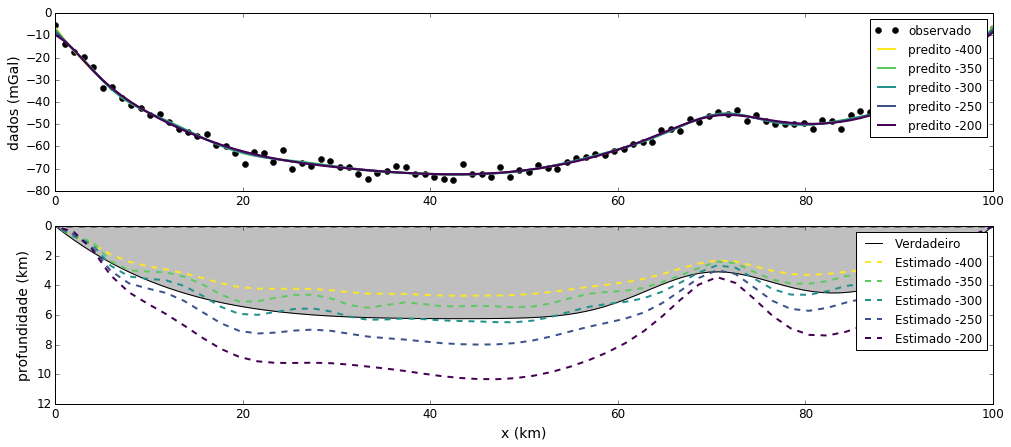

In [5]:
range_colors = np.linspace(1., 0., rhos.size)
colors = matplotlib.cm.get_cmap('viridis')

factor = 1.4
plt.close('all')
plt.figure(figsize=(factor*12,factor*5))
plt.subplot(2, 1, 1)
plt.plot(0.001*x, data, 'ok', label='observado')
for rc, rho, solver in zip(range_colors, rhos, solvers):
    plt.plot(0.001*x, solver[0].predicted(), linestyle = 'solid', color = colors(rc), 
             linewidth=2, label='predito %.0f' % (rho))
plt.legend(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('dados (mGal)', fontsize=14)
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5, label='Verdadeiro')
# The estimate_ property of our solver gives us the estimate basin as a polygon
# So we can directly pass it to plotting and forward modeling functions
for rc, rho, solver in zip(range_colors, rhos, solvers):
    line = mpl.polygon(solver.estimate_, style='--', linewidth = 2, 
                       label='Estimado %.0f' % (rho))
    line.set_color(colors(rc))
ax.invert_yaxis()
mpl.m2km()
plt.legend(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('profundidade (km)', fontsize=14)
plt.xlabel('x (km)', fontsize=14)
plt.savefig('estimativas.png', dpi=300)
plt.show()